<center> <h1> DS202: Group Data Project </h1> </center>
<center> <h2> Analysis of the ADS: Give Me Some Credit Kaggle Competition </h2> </center>
<center> <i>  Grace Yang, Elaine Shan </i> </center>

In [23]:
# Main tools we used:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Models:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Python utilities:
import time
import os


# Data Exploration

First let's take a look at what our predictors are:

In [24]:
df = pd.read_csv('cs-training.csv')
list(df)
print(df.shape)

(150000, 12)


In [25]:
test_df = pd.read_csv('cs-test.csv')
print(test_df.shape)

(101503, 12)


# SeriousDlqin2yrs

We also want to know how balanced the data set is, so we check what portion defaulted:

In [26]:
df.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

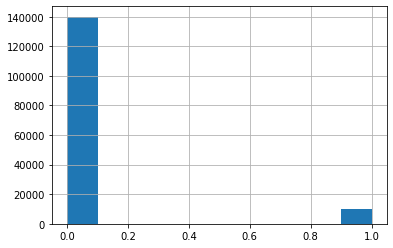

In [27]:
df['SeriousDlqin2yrs'].hist()

In [28]:
df.SeriousDlqin2yrs.mean()

0.06684

In [29]:
df.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

# Age

"If you're over 55 and need a mortgage, the important thing to know if that lenders can't deny you a loan based on your age. But age can factor into your mortgage equation." ([Source](https://www.chicagotribune.com/news/ct-xpm-2005-11-20-0511200488-story.html))

This should be our first concern: making sure we're in legally okay territory. In order to solve this, we need to confirm that in our data set age has a negative influence on probability of defaulting. Then we can assume that the models we build reflect that trend, and won't deny someone a loan simply because they are old. 

In [30]:
df.age.describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [9]:
df.age.isna().sum()

1

Text(0.5, 1.0, 'SeriousDlqin2yrs = 1')

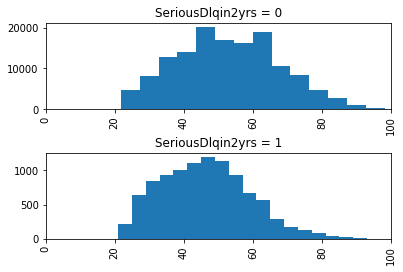

In [10]:
age_hist = df['age'].hist(by=df['SeriousDlqin2yrs'], bins=20, layout=(2,1))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')

Nice! Looking at the distribution of people that defaulted vs those who did not shows us that, generally, younger people were more responsible for defaulting. So we're good to go, legally. 

# DebtRatio

Let's take a look at our data. We can start with Debt Ratio, the ratio of debt to assets. 

In [10]:
df.DebtRatio.describe()

count     42040.000000
mean        362.118183
std        2187.453550
min           0.000000
25%           0.174878
50%           0.368889
75%           0.880248
max      326442.000000
Name: DebtRatio, dtype: float64

In [ ]:
df.DebtRatio.isna().sum()

0

It is very concerning that someone owes 330,000 times what they own. Maybe that person is a single outlier? Let's take a look:

In [ ]:
df.DebtRatio.quantile([.975])

0.975    3489.025
Name: DebtRatio, dtype: float64

Apparently 2.5% of the dataset owes more than 3,500 times what they own. We need to investigate further to see if these are outliers or not. We can see:

In [ ]:
df[df['DebtRatio'] > 3489.025][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,3750.000000,185.000000
mean,0.064267,0.064865
std,0.245260,0.246956
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


We see two particularly concerning things here. The first is that of 4,000 records with DebtRatio > 3,500, only 185 of them have a value for monthly income. Further, the people who do have monthly income seem to either have a monthly income of either 1 or 0. We see that: 

In [ ]:
df[(df['DebtRatio'] > 3489.025) & (df['SeriousDlqin2yrs'] == df['MonthlyIncome'])].shape[0]

164

...of those 185 entries, 164 of them have the same value for 2 year default rate and monthly income, indicating that there is a data-entry error. 

The second problem is that despite owing thousands of times what they own, these people aren't defaulting any more than the general population. We can conclude that these entries must be data-entry errors, so we will remove them from our model.

# Monthly income

In [ ]:
df.MonthlyIncome.describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

Check how many entries hava nan in MonthlyIncome

In [ ]:
df.MonthlyIncome.isna().sum()

29731

# NumberOfTimes90DaysLate.

Now let's take a look at NumberOfTimes90DaysLate.

In [ ]:
df.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()

NumberOfTimes90DaysLate
0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

It is interesting that no one is between 17 and 96 times late, but hundreds of people are 98 times late. We can take a look at these few hundred records:

In [ ]:
df[df['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

,SeriousDlqin2yrs,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,269.000000,269.000000,269.000000,269.000000
mean,0.546468,97.962825,97.962825,97.962825
std,0.498764,0.270628,0.270628,0.270628
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


Somehow, all these (300) people were 30-59 days late 96/98 times, 60-89 days late 96/98 times, and 90+ days late 96/98 times. This is really concerning.  However, the data might not be garbage, because (as expected) these people are defaulting at a massive rate (55%) compared to the population (6%). So we don't want to throw away this data. We can Winsorize by replacing all the 96/98s with 20s to make them not extreme outliers and see if that improves the models. We don't expect that to improve the random forests, which are robust to outliers, but it might improve the SVMs.

Finally, let's take a look at revolving utilization of unsecured lines. It represents the ratio of money owed to credit limit, so it shouldn't get much above 1. First let's look at values close to 1 and see at what rate they're defaulting. We start with 0.9 to 4.0:

In [ ]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > .9) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 4)].SeriousDlqin2yrs.describe()

count    19805.000000
mean         0.225347
std          0.417821
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64

# NumberOfOpenCreditLinesAndLoans

In [ ]:
df['NumberRealEstateLoansOrLines'].describe()

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

Check how many entries have nan in NumberRealEstateLoansOrLines

In [ ]:
df.NumberRealEstateLoansOrLines.isna().sum()

0

# NumberOfTime30-59DaysPastDueNotWorse

In [ ]:
df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
98       264
6        140
7         54
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

Check how many entries have nan in NumberOfTimes60-89DaysPastDueNotWorse

In [ ]:
df['NumberOfTime60-89DaysPastDueNotWorse'].isna().sum()

0

# NumberOfDependents

In [ ]:
df['NumberOfDependents'].value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

Check how many entries have nan in NumberOfDependents

In [ ]:
df['NumberOfDependents'].isna().sum()

3924

# NumberOfTimes60-89DaysPastDueNotWorse

In [ ]:
df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

0     142396
1       5731
2       1118
3        318
98       264
4        105
5         34
6         16
7          9
96         5
8          2
11         1
9          1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

These 20,000 people are defaulting at a rate of almost 1-in-4. This is important! But what about people with more RUUL? Let's consider 4 to 10:

In [ ]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 4) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 10)].SeriousDlqin2yrs.describe()

count    23.000000
mean      0.260870
std       0.448978
min       0.000000
25%       0.000000
50%       0.000000
75%       0.500000
max       1.000000
Name: SeriousDlqin2yrs, dtype: float64

There are only 23 records in this region, but they're still defaulting at a high rate. What about if we go even higher, and consider those with RUUL > 10?

In [ ]:
df[df['RevolvingUtilizationOfUnsecuredLines'] > 10].SeriousDlqin2yrs.describe()

count    241.000000
mean       0.070539
std        0.256587
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: SeriousDlqin2yrs, dtype: float64

These 241 people are not defaulting any more than anyone else, despite some of them owing hundreds of thousands of times their credit limits. These seem to be inconsistent with the rest of the data, so we can remove them from our model.



# NumberOfOpenCreditLinesAndLoans

In [ ]:
df['NumberOfOpenCreditLinesAndLoans'].describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

Check how many entries have nan in NumberOfOpenCreditLinesANdLoans

In [ ]:
df['NumberOfOpenCreditLinesAndLoans'].isna().sum()

0



Finally, let's take a look at using regression to fill in the missing values for MonthlyIncome:

In [ ]:
not_missing = df.dropna()
target = 'MonthlyIncome'
predictors = [c for c in list(not_missing) if c not in [target, 'Unnamed: 0','SeriousDlqin2yrs']]
X_data = not_missing[predictors]
y_data = not_missing[target]
regr = LinearRegression().fit(X_data, y_data)

In [ ]:
regr.score(X_data, y_data)

0.02201505632577072

This is a terrible $R^2$. It seems that our best bet is to just replace the missing values with the median (instead of the mean, because there are some extreme outliers in MonthlyIncome, who are making millions of dollars a month). The other column with missing values is NumberOfDependents. >50% of the non-missing values have 0 dependents, and if someone leaves the field blank it is likely to be due to not having any dependents, we'll replace these values with 0.

## Datasets

Based on all of these insights, we built some datasets that will potentially improve our model performance:

In [4]:
# Median Fill, Outliers Removed
removed_debt_outliers = df.drop(df[df['DebtRatio'] > 3489.025].index)
removed_debt_outliers = removed_debt_outliers.fillna(removed_debt_outliers.median())

In [5]:
# Removed utilization outliers
dfus = removed_debt_outliers.drop(removed_debt_outliers[removed_debt_outliers['RevolvingUtilizationOfUnsecuredLines'] > 10].index)

In [6]:
# Removed 98s
dfn98 = dfus.copy()
dfn98.loc[dfn98['NumberOfTime30-59DaysPastDueNotWorse'] > 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 18
dfn98.loc[dfn98['NumberOfTime60-89DaysPastDueNotWorse'] > 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 18
dfn98.loc[dfn98['NumberOfTimes90DaysLate'] > 90, 'NumberOfTimes90DaysLate'] = 18

# after data cleaning

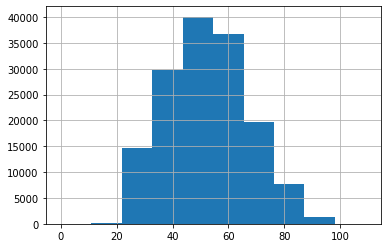

In [31]:
df.age.hist()

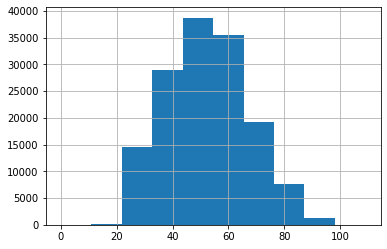

In [15]:
dfus.age.hist()

the filtering process does not change the distribution of age in the dataset

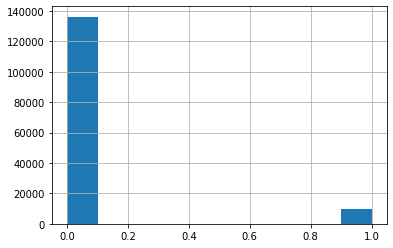

In [16]:
dfus['SeriousDlqin2yrs'].hist()

In [17]:
count1 = dfus[dfus['SeriousDlqin2yrs']==1].shape[0]
count0 = dfus[dfus['SeriousDlqin2yrs']==0].shape[0]
print('base rate of delinquency: ',count1/count0)

base rate of delinquency:  0.07169803012065878


In [18]:
dfn98.NumberOfDependents.isna().sum()

0

correlation between different attributes

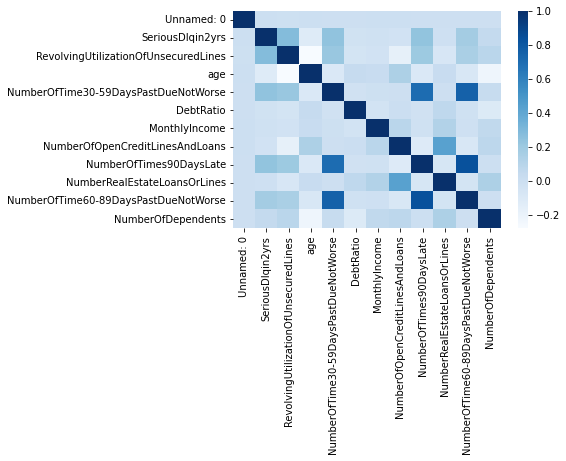

In [19]:
import seaborn as sb
corr = dfn98.corr()
sb.heatmap(corr, cmap="Blues")

We will revisit these in the next section.

# Model Testing

To be able to rapidly test our models and datasets and see how they compare against each other, we developed a tester program that automatically runs k-fold cross-validation on scikit models accross different datasets. 

In [20]:
# A utility class to test all of our models on different datasets
class Tester():
    def __init__(self, target):
        self.target = target
        self.datasets = {}
        self.models = {}
        self.cache = {} # we added a simple cache to speed things up

    def addDataset(self, name, df):
        self.datasets[name] = df.copy()

    def addModel(self, name, model):
        self.models[name] = model
        
    def clearModels(self):
        self.models = {}

    def clearCache(self):
        self.cache = {}
    
    def testModelWithDataset(self, m_name, df_name, sample_len, cv):
        if (m_name, df_name, sample_len, cv) in self.cache:
            return self.cache[(m_name, df_name, sample_len, cv)]

        clf = self.models[m_name]
        
        if not sample_len: 
            sample = self.datasets[df_name]
        else: sample = self.datasets[df_name].sample(sample_len)
            
        X = sample.drop([self.target], axis=1)
        Y = sample[self.target]
        s = cross_validate(clf, X, Y, scoring=['roc_auc'], cv=cv, n_jobs=-1)
        self.cache[(m_name, df_name, sample_len, cv)] = s
        return s
    

    def runTests(self, sample_len=80000, cv=4):
        # Tests the added models on all the added datasets
        scores = {}
        for m_name in self.models:
            for df_name in self.datasets:
                # print('Testing %s' % str((m_name, df_name)), end='')
                start = time.time()

                score = self.testModelWithDataset(m_name, df_name, sample_len, cv)
                scores[(m_name, df_name)] = score
                
                
                end = time.time()
                
                # print(' -- %0.2fs ' % (end - start))

        print('--- Top 10 Results ---')
        for score in sorted(scores.items(), key=lambda x: -1 * x[1]['test_roc_auc'].mean())[:10]:
            auc = score[1]['test_roc_auc']
            print("%s --> AUC: %0.4f (+/- %0.4f)" % (str(score[0]), auc.mean(), auc.std()))
    


            
# We will use a tester object across all models
tester = Tester('SeriousDlqin2yrs')

# You can add datasets like this:
tester.addDataset('Drop Missing', df.dropna())

# And models like this:
rfc = RandomForestClassifier(n_estimators=15, max_depth = 6, random_state=0)
tester.addModel('Simple Random Forest', rfc)
tester.addModel('Simple SVM', svm.LinearSVC())

# You can then use it to run the tests
tester.runTests()

--- Top 10 Results ---
('Simple Random Forest', 'Drop Missing') --> AUC: 0.8494 (+/- 0.0047)
('Simple SVM', 'Drop Missing') --> AUC: 0.5810 (+/- 0.0298)


Now that we have this tester up and running, let's go back to the datasets we created in our data exploration section. We can easily add them to the tester program to see how our models perform on them.

In [21]:
tester.addDataset('Median Fill', df.fillna(df.median()))
tester.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester.addDataset('Removed 98s', dfn98)
tester.addDataset('Removed utilization outliers', dfus)
tester.runTests()

--- Top 10 Results ---
('Simple Random Forest', 'Removed 98s') --> AUC: 0.8605 (+/- 0.0030)
('Simple Random Forest', 'Median Fill, Outliers Removed') --> AUC: 0.8584 (+/- 0.0027)
('Simple Random Forest', 'Removed utilization outliers') --> AUC: 0.8584 (+/- 0.0031)
('Simple Random Forest', 'Median Fill') --> AUC: 0.8578 (+/- 0.0074)
('Simple Random Forest', 'Drop Missing') --> AUC: 0.8494 (+/- 0.0047)
('Simple SVM', 'Removed utilization outliers') --> AUC: 0.6334 (+/- 0.0237)
('Simple SVM', 'Removed 98s') --> AUC: 0.6328 (+/- 0.0425)
('Simple SVM', 'Median Fill, Outliers Removed') --> AUC: 0.6113 (+/- 0.0054)
('Simple SVM', 'Drop Missing') --> AUC: 0.5810 (+/- 0.0298)
('Simple SVM', 'Median Fill') --> AUC: 0.5721 (+/- 0.0500)


We noticed that the modified datasets have a big influence on the SVM AUC scores, but they don't affect the Random Forests as much. However, there's a noticeable gain in performance between simply dropping the missing values and the modified datasets accross all models. 

('Simple Random Forest', 'Removed 98s') --> AUC: 0.8605 (+/- 0.0030) seems to produce the best result

## Random Forests

Random Forests seemed to be the best bet, so we decided to move forward with them and figure out the best tuning parameters. Running two for-loops allowed us to find the best value for max_depth and number of estimators, with our best model being the random forest with a depth of 9 and 16 estimators. When we use the data set that removes the RUUL outliers, it gives us an AUC of .8662. 

In [22]:
from sklearn.ensemble import RandomForestClassifier

for i in range(5,10):
    for j in range(10,20):
        rfc = RandomForestClassifier(n_estimators=j,max_depth = i, random_state=0)
        tester.addModel('Random Forest '+'d: '+str(i)+' est: '+str(j)  ,rfc)
tester.runTests()

KeyboardInterrupt: ignored

# use RandomForestClassifier to make predictions and see its result on different age groups

'Simple Random Forest', 'Removed utilization outliers') --> AUC: 0.8615 (+/- 0.0059)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [33]:
target = 'SeriousDlqin2yrs'
X = dfus.drop([target], axis=1)
y = dfus[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.drop(X_train.columns[0], axis=1, inplace=True)
X_test.drop(X_test.columns[0], axis=1, inplace = True)


model = RandomForestClassifier(n_estimators=16,max_depth = 9, random_state=0)

In [34]:
print("size of training dataset: ",len(y_train),"size of test dataset: ", len(y_test))

size of training dataset:  102214 size of test dataset:  43807


In [35]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_pred = X_test.copy()
test_pred['prediction'] = list(y_pred)


In [36]:
print('outcomes:')
pd.DataFrame(y_pred).value_counts()


outcomes:


0    42904
1      903
dtype: int64

In [31]:
test_pred

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,prediction
140034,0.985119,51,0,0.202032,9250.0,5,0,1,0,0.0,0
141589,1.000000,45,0,0.000000,3600.0,0,0,0,0,1.0,0
111745,1.000000,58,0,1.000000,5400.0,2,0,0,0,2.0,0
77027,0.298207,55,0,0.456951,5063.0,12,0,1,0,2.0,0
3042,0.009395,61,1,1744.000000,5400.0,11,0,1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
83281,0.033397,51,0,0.778740,3000.0,10,0,2,0,0.0,0
32987,0.002125,90,0,0.000000,6500.0,4,0,0,0,0.0,0
34636,0.156829,55,1,0.070794,4166.0,5,0,0,0,0.0,0
61953,0.133022,73,0,0.284520,12079.0,12,0,2,0,0.0,0


In [37]:
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('accuracy: ', accuracy)
print('auc:', auc)

accuracy:  0.9377496747095213
auc: 0.5865963364026058


Let's put our data back into a aif360 dataset format, so that we can use all of the fairness metrics provided by the package. For now, we'll evaluate bias on the training data. This mimics the development process we'd use in any real application.

First, we'll get predicted values using the best model and attach them as a new column in the data frame. 

In [13]:
!pip install aif360
!pip install numba

In [38]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import GermanDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing

In [39]:
train_orig_df = X_train.copy()
train_orig_df['prediction'] = list(y_train)
train_pred = X_train.copy()
train_pred['prediction'] = list(model.predict(X_train))
test_orig_df = X_test.copy()
test_orig_df['prediction'] = list(y_test)

In [48]:
train_orig_df.loc[train_orig_df['age']<50, 'age']=0
train_orig_df.loc[train_orig_df['age']>=50, 'age']=1
train_pred.loc[train_pred['age']<50, 'age']=0
train_pred.loc[train_pred['age']>=50, 'age']=1
test_pred.loc[test_pred['age']<50, 'age']=0
test_pred.loc[test_pred['age']>=50, 'age']=1
test_orig_df.loc[test_orig_df['age']<50, 'age']=0
test_orig_df.loc[test_orig_df['age']>=50, 'age']=1

In [49]:
train_pred

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,prediction
80280,0.071052,0,0,122.000000,5400.0,5,0,0,0,0.0,0
75754,0.064143,0,0,1.099189,3205.0,13,0,1,0,0.0,0
115915,0.030242,0,0,0.015276,2683.0,8,0,0,0,0.0,0
101414,0.005506,0,0,0.249780,9083.0,4,0,2,0,0.0,0
127809,0.388851,0,1,0.122986,9000.0,8,0,1,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...
113303,0.000000,0,0,0.275718,3100.0,2,0,1,0,0.0,0
123178,0.763236,0,0,0.499252,6683.0,10,0,2,0,0.0,0
106564,0.126144,0,0,0.395285,4750.0,7,0,1,0,0.0,0
135546,0.241561,0,0,0.436420,7808.0,7,0,2,0,1.0,0


In [50]:
train_orig_df

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,prediction
80280,0.071052,0,0,122.000000,5400.0,5,0,0,0,0.0,0
75754,0.064143,0,0,1.099189,3205.0,13,0,1,0,0.0,0
115915,0.030242,0,0,0.015276,2683.0,8,0,0,0,0.0,0
101414,0.005506,0,0,0.249780,9083.0,4,0,2,0,0.0,0
127809,0.388851,0,1,0.122986,9000.0,8,0,1,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...
113303,0.000000,0,0,0.275718,3100.0,2,0,1,0,0.0,0
123178,0.763236,0,0,0.499252,6683.0,10,0,2,0,0.0,0
106564,0.126144,0,0,0.395285,4750.0,7,0,1,0,0.0,0
135546,0.241561,0,0,0.436420,7808.0,7,0,2,0,1.0,0


Now, let's calculate some fairness metrics for `orig_aif360` and `preds_aif360`. Calculate the mean difference and disparate impact below (again using `BinaryLabelDatasetMetric`):

In [44]:
train_orig_aif360 = StandardDataset(train_orig_df, 
                          label_name='prediction', 
                          favorable_classes=[0], 
                          protected_attribute_names=['age'], 
                          privileged_classes=[[1]])

train_pred_aif360 = StandardDataset(train_pred, 
                          label_name='prediction', 
                          favorable_classes=[0], 
                          protected_attribute_names=['age'], 
                          privileged_classes=[[1]])
test_orig_aif360 = StandardDataset(test_orig_df, 
                          label_name='prediction', 
                          favorable_classes=[0], 
                          protected_attribute_names=['age'], 
                          privileged_classes=[[1]])

test_pred_aif360 = StandardDataset(test_pred, 
                          label_name='prediction', 
                          favorable_classes=[0], 
                          protected_attribute_names=['age'], 
                          privileged_classes=[[1]])


In [46]:
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]
train_orig_metrics = BinaryLabelDatasetMetric( train_orig_aif360, 
     unprivileged_groups= unprivileged_groups,
     privileged_groups = privileged_groups)

train_pred_metrics = BinaryLabelDatasetMetric( train_pred_aif360, 
     unprivileged_groups= unprivileged_groups,
     privileged_groups = privileged_groups)
test_orig_metrics = BinaryLabelDatasetMetric( test_orig_aif360, 
     unprivileged_groups= unprivileged_groups,
     privileged_groups = privileged_groups)

test_pred_metrics = BinaryLabelDatasetMetric( test_pred_aif360, 
     unprivileged_groups= unprivileged_groups,
     privileged_groups = privileged_groups)


In [51]:
print("Train original metric: Mean difference = %f" %train_orig_metrics.mean_difference())
print("Train original metric: Disparate impact = %f" %train_orig_metrics.disparate_impact()) 
print("Train predicted metric: Mean difference = %f" %train_pred_metrics.mean_difference())
print("Train predicted metric: Disparate impact = %f" %train_pred_metrics.disparate_impact()) 
print("Test original metric: Mean difference = %f" %test_orig_metrics.mean_difference())
print("Test original metric: Disparate impact = %f" %test_orig_metrics.disparate_impact()) 
print("Test predicted metric: Mean difference = %f" %test_pred_metrics.mean_difference())
print("Test predicted metric: Disparate impact = %f" %test_pred_metrics.disparate_impact()) 

Train original metric: Mean difference = -0.052929
Train original metric: Disparate impact = 0.945005
Train predicted metric: Mean difference = -0.022389
Train predicted metric: Disparate impact = 0.977414
Test original metric: Mean difference = -0.051321
Test original metric: Disparate impact = 0.946730
Test predicted metric: Mean difference = -0.022865
Test predicted metric: Disparate impact = 0.976958


we identified bias in the training data. We should therefore not find it surprising that we have bias in a model trained on that data.

Now, since we have true values and predicted values, let's compare the true positive rate and false positive rate by group. This is similar to the analysis ProPublica did. We can use the `ClassificationMetric` function to do this.

Note that aif360 is pretty picky about what goes into this `ClassificationMetric` class, which is the reason for all the inefficient copying of datasets above. 

In [21]:
orig_vs_preds_metrics = ClassificationMetric(train_orig_aif360, train_pred_aif360,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [52]:
print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())
print("\nFalse negative rate for privileged groups(age <55) = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups(age >=55) = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())
print("\nFalse positive rate for privileged groups (age<55)= %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups (age>=55)= %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())


Error rate difference (unprivileged error rate - privileged error rate)= -0.044058

False negative rate for privileged groups(age <55) = 0.009039
False negative rate for unprivileged groups(age >=55) = 0.001520
False negative rate ratio = 0.168131

False positive rate for privileged groups (age<55)= 0.746940
False positive rate for unprivileged groups (age>=55)= 0.806471
False positive rate ratio = 1.079700


The false nagative rates between the privileged groups and the unprivileged groups are similar(0.747 and 0.806). 

Though the false positive rates in both groups are small. the false positive rate for the unprivileged groups is 0.16 times the false positibe rate for the privileged groups. The model will be slightly more likely to underestimate the default risk of people with age smaller than 55 and overestimate the default risk of people with age greater than 55, but the model is overall fair across different age groups.

Transparancy:

In [53]:
!pip install shap==0.39.0

In [54]:
%matplotlib inline
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
shap.initjs()



In [55]:
target = 'SeriousDlqin2yrs'
X = dfus.drop([target], axis=1)
y = dfus[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.drop(X_train.columns[0], axis=1, inplace=True)
X_test.drop(X_test.columns[0], axis=1, inplace = True)

In [56]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=0.1)

In [ ]:
sklearn.metrics.accuracy_score(model.predict(X_test), y_test)

In [57]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


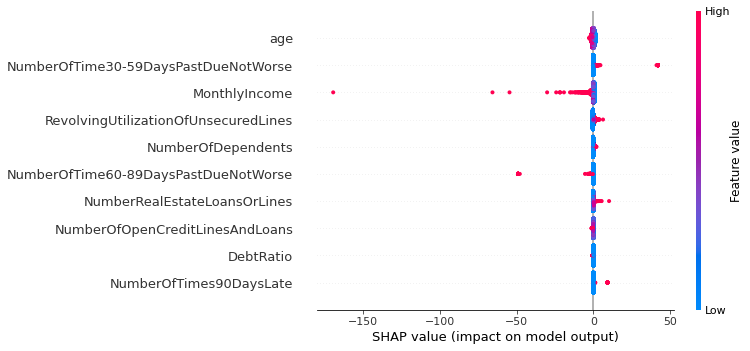

In [99]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

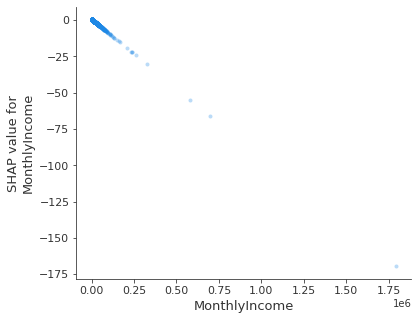

In [108]:
shap.dependence_plot('MonthlyIncome', shap_values, X_test, alpha=0.3, interaction_index=None)

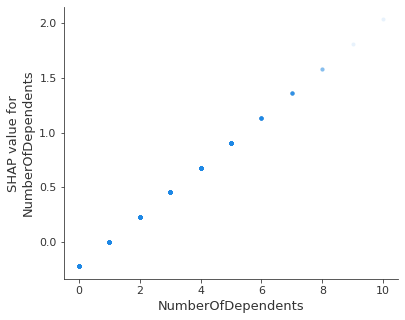

In [110]:
shap.dependence_plot('NumberOfDependents', shap_values, X_test, alpha=0.1, interaction_index=None)

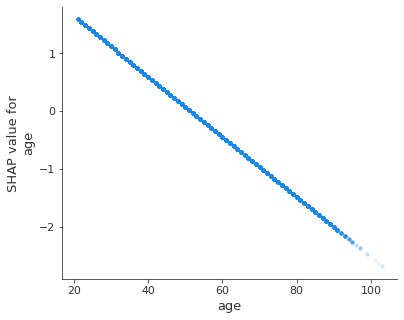

In [58]:
shap.dependence_plot('age', shap_values, X_test, alpha=0.1, interaction_index=None)

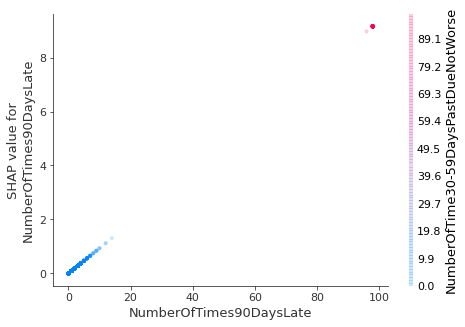

In [113]:
shap.dependence_plot('NumberOfTimes90DaysLate', shap_values, X_test, alpha=0.2, interaction_index='NumberOfTime30-59DaysPastDueNotWorse')

In [106]:
shap.initjs()
idx = 3
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], np.asarray(X_test)[idx,:],
    feature_names=X_test.columns
)

In [114]:
idx = 3
vals = shap_values[idx,:]
positive_weight = defaultdict(float)
negative_weight = defaultdict(float)
feats = X_test.columns

for feat_i, val_i in zip(feats, vals):
  if val_i > 0:
    positive_weight[feat_i] += val_i
  elif val_i < 0:
    negative_weight[feat_i] += val_i

In [118]:
print("Features contributing positively: ")
print(list(sorted(positive_weight.items(), key=operator.itemgetter(1), reverse=True)))
print("Features contributing negatively")
print(list(sorted(negative_weight.items(), key=operator.itemgetter(1), reverse=True)))

Features contributing positively: 
[('NumberOfDependents', 0.22813602362019433), ('MonthlyIncome', 0.10465104216082206), ('NumberOfTime60-89DaysPastDueNotWorse', 0.04501833142453436), ('DebtRatio', 0.028808927297183585), ('NumberRealEstateLoansOrLines', 0.009640522460943797)]
Features contributing negatively
[('NumberOfTimes90DaysLate', -0.008422658057246143), ('RevolvingUtilizationOfUnsecuredLines', -0.035657661182161654), ('NumberOfOpenCreditLinesAndLoans', -0.09005234920450421), ('NumberOfTime30-59DaysPastDueNotWorse', -0.14633528218103484), ('age', -0.18519998073909322)]


In [ ]:
## K-Nearest Neighbors

We were also curious to see how a simpler learner would perform, so we tested a simple K-Nearest Neighbors model. Unsurprisingly, the results were not that great.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

tester.clearModels()

for i in range(5, 10):
    neigh = KNeighborsClassifier(n_neighbors=i)
    tester.addModel('KNN k=%d' % i, neigh)
    
tester.runTests(50000)

--- Top 10 Results ---
('KNN k=9', 'Removed utilization outliers') --> AUC: 0.5231 (+/- 0.0060)
('KNN k=6', 'Drop Missing') --> AUC: 0.5230 (+/- 0.0062)
('KNN k=8', 'Median Fill') --> AUC: 0.5221 (+/- 0.0065)
('KNN k=6', 'Median Fill, Outliers Removed') --> AUC: 0.5207 (+/- 0.0068)
('KNN k=6', 'Removed 98s') --> AUC: 0.5201 (+/- 0.0046)
('KNN k=9', 'Drop Missing') --> AUC: 0.5172 (+/- 0.0058)
('KNN k=9', 'Median Fill, Outliers Removed') --> AUC: 0.5168 (+/- 0.0077)
('KNN k=8', 'Median Fill, Outliers Removed') --> AUC: 0.5162 (+/- 0.0084)
('KNN k=6', 'Removed utilization outliers') --> AUC: 0.5153 (+/- 0.0068)
('KNN k=5', 'Removed utilization outliers') --> AUC: 0.5145 (+/- 0.0016)


## Neural Network

On the other end of the spectrum, we were also curious about trying out really fancy models, so we created and ran a neural network on the data. While K-Nearest-Neighbors was the weakest model we could think to run, a neural network was the strongest thing we could think to do. We expected its performance to be quite high, but discovered exactly the opposite. When initially training the network, we were excited to see it classifying 93% of examples correctly until we realized that it was guessing the same value every time. Essentially, the neural network was not learning a real decision boundary but was instead capitalizing on the imbalance on our data to achieve a high accuracy score. In order to combat this, we attempted to weight our classes differently, but unfortunately were unsuccessful. If we had wanted to, we could have pursued undersampling in order to balance the sample. However, we decided it would be best to not throw away large portions of our data. Because of this in combination with the fact that we do not fully understand the inner workings of a neural network, we decided to use a model whose theory we did understand and that enabled us to take advantage of all of the data.